# Recap (can be skipped): Create the tabular data for 10s-3s windows

In [5]:
"""
Loading the original dataset
"""

import pandas as pd

data_path = '/content/drive/MyDrive/Colab Data/ai_in_rehab_2025_tutorial/'
n_subjects = 24

trials = {
    'downstairs': {'dws_1', 'dws_2', 'dws_11'},
    'upstairs': {'ups_3', 'ups_4', 'ups_12'},
    'walking': {'wlk_7', 'wlk_8', 'wlk_15'},
    'sitting': {'sit_5', 'sit_13'},
    'standing': {'std_6', 'std_14'},
    'jogging': {'jog_9', 'jog_16'}
}

import pandas as pd
import numpy as np

def load_with_timestamp(path, sample_rate=50):
    df = pd.read_csv(path)

    # remove the unnamed first col (sample index from file)
    df = df.drop(df.columns[0], axis=1)

    # compute timestamps (ns precision to avoid float issues)
    n_samples = len(df)
    timestamps = np.arange(n_samples) * (1e9 / sample_rate)  # in nanoseconds
    # make into datetime64[ns] starting at unix epoch (0)
    df.insert(0, "datetime", pd.to_datetime(timestamps, unit="ns"))

    timestamps = np.arange(n_samples) / sample_rate  # [0, 0.02, 0.04, ...]
    df.insert(1, "timestamp", timestamps)

    return df


data = {}

for i_subject in range(1, n_subjects+1):
  subject = f'sub_{i_subject}'
  data[subject] = {}
  for activity in trials.keys():
    data[subject][activity] = {}
    for trial in trials[activity]:
      df_acc_path = data_path + f'Accelerometer_data/{trial}/{subject}.csv'
      df_acc = load_with_timestamp(df_acc_path)
      df_gyro_path = data_path + f'Gyroscope_data/{trial}/{subject}.csv'
      df_gyro = load_with_timestamp(df_gyro_path)

      data[subject][activity][trial] = {
          "acc": df_acc,
          "gyro": df_gyro
      }
  print(f"Loaded {subject}")



In [ ]:
"""
Creating the low-pass filter
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

def butter_lowpass_filter(data, cutoff, fs, order=3):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y


def apply_lowpass_filter(df, cutoff=10, fs=50, order=3, plot=False):
    """
    Applies a low-pass filter to a dataframe with columns:
      - 'timestamp' (in seconds)
      - one signal column (e.g. x, y, z)
    Adds a 'filtered' column and plots before vs after.
    """
    # Identify the signal column (everything except 'timestamp')
    value_cols = [col for col in df.columns if col != 'timestamp']
    if len(value_cols) != 1:
        raise ValueError("DataFrame must have exactly one signal column besides 'timestamp'")
    value_col = value_cols[0]

    # Extract
    t = df['timestamp'].values
    x = df[value_col].values

    # Filter
    x_filtered = butter_lowpass_filter(x, cutoff, fs, order)

    if plot == True:
      # Plot
      plt.figure(figsize=(12, 6))
      plt.plot(t, x, label='Before Filter', alpha=0.7)
      plt.plot(t, x_filtered, label=f'After Low-pass Filter ({cutoff} Hz)', linestyle='--', linewidth=2)
      plt.xlabel('Time (s)')
      plt.ylabel(value_col)
      plt.title(f'Low-pass Filter applied to {value_col}')
      plt.legend()
      plt.grid(True)
      plt.show()

    # Return dataframe with filtered column
    df_out = df.copy()
    df_out['filtered'] = x_filtered
    return df_out


In [ ]:
"""
Filtering the data
"""

filtered_data = {}

for subject in data:
    filtered_data[subject] = {}
    for activity in data[subject]:
        filtered_data[subject][activity] = {}
        for trial in data[subject][activity]:
            filtered_data[subject][activity][trial] = {}

            for sensor in data[subject][activity][trial]:
                for axis in ['x', 'y', 'z']:
                    modality_name = f"{sensor}_{axis}"
                    modality = data[subject][activity][trial][sensor][['timestamp', axis]]
                    modality_filtered = apply_lowpass_filter(modality, cutoff=10, fs=50, order=3, plot=False)

                    # save under modality instead of sensor
                    filtered_data[subject][activity][trial][modality_name] = modality_filtered


In [ ]:
"""
Create the featured dataset + windowing
"""

import numpy as np
import pandas as pd
from scipy.fft import fft, fftfreq
from scipy.stats import skew, kurtosis

window_size = 10.0  # seconds
step_size = 3.0     # seconds
fs = 50

feature_rows = []

for subject in filtered_data:
    for activity in filtered_data[subject]:
        for trial in filtered_data[subject][activity]:

            trial_length = []
            for modality_name, modality_df in filtered_data[subject][activity][trial].items():
              trial_length.append(modality_df.shape[0])


            n_samples = np.min(trial_length)
            win_samples = int(window_size * fs)
            step_samples = int(step_size * fs)

            for i_window, start_idx in enumerate(range(0, n_samples - win_samples + 1, step_samples)):
              end_idx = start_idx + win_samples
              row_features = {
                "subject": subject,
                "activity": activity,
                "trial": trial,
                "window": i_window
                }

              for modality_name, modality_df in filtered_data[subject][activity][trial].items():
                  signal = modality_df['filtered'].values
                  time = modality_df['timestamp'].values

                  window_signal = signal[start_idx:end_idx]
                  window_time = time[start_idx:end_idx]


                  # --- Time-domain features ---
                  mean_val = np.mean(window_signal)
                  std_val = np.std(window_signal)
                  peak_to_peak = np.ptp(window_signal)
                  signal_skew = skew(window_signal)
                  signal_kurt = kurtosis(window_signal)

                  # --- Amplitude-domain features ---
                  max_amp = np.max(window_signal)
                  min_amp = np.min(window_signal)
                  rms_amp = np.sqrt(np.mean(window_signal**2))

                  # --- Spectral-domain features ---
                  signal_fft = fft(window_signal)
                  freqs = fftfreq(len(window_signal), d=1/fs)
                  power_spectrum = np.abs(signal_fft)**2

                  if len(power_spectrum) > 1:
                      dominant_idx = np.argmax(power_spectrum[1:]) + 1
                      dominant_freq = freqs[dominant_idx]
                      dominant_power = power_spectrum[dominant_idx]
                  else:
                      dominant_freq = np.nan
                      dominant_power = np.nan

                  # prefix all feature names with the modality
                  prefix = modality_name
                  row_features.update({
                      f"{prefix}_mean": mean_val,
                      f"{prefix}_std": std_val,
                      f"{prefix}_ptp": peak_to_peak,
                      f"{prefix}_skew": signal_skew,
                      f"{prefix}_kurtosis": signal_kurt,
                      f"{prefix}_max": max_amp,
                      f"{prefix}_min": min_amp,
                      f"{prefix}_rms": rms_amp,
                      f"{prefix}_dom_freq": dominant_freq,
                      f"{prefix}_dom_power": dominant_power
                  })

              # add this trial’s feature row
              feature_rows.append(row_features)

# ---- Combine into one DataFrame ----
features_df = pd.DataFrame(feature_rows)


In [ ]:
"""
Save the featured dataset on the drive
"""


data_path = '/content/drive/MyDrive/Colab Data/ai_in_rehab_2025_tutorial/'

save_path = data_path + 'features_df_10s_3s.csv'  # or another name you prefer
features_df.to_csv(save_path, index=False)
print(f"Saved features_df to {save_path}")


# Load the tabular dataset

In [6]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# loading the tabular features for the whole trials

In [9]:
# Load the featured dataset

import pandas as pd

data_path = '/content/drive/MyDrive/Colab Data/ai_in_rehab_2025_tutorial/'
load_path = data_path + 'features_df_trial.csv'
# load_path = data_path + 'features_df_10s_3s.csv'


features_df = pd.read_csv(load_path)
print(f"Loaded features_df from {load_path}")
print(features_df.shape)
features_df.head()


Loaded features_df from /content/drive/MyDrive/Colab Data/ai_in_rehab_2025_tutorial/features_df_trial.csv
(360, 63)


,subject,activity,trial,acc_x_mean,acc_x_std,acc_x_ptp,acc_x_skew,acc_x_kurtosis,acc_x_max,acc_x_min,...,gyro_z_mean,gyro_z_std,gyro_z_ptp,gyro_z_skew,gyro_z_kurtosis,gyro_z_max,gyro_z_min,gyro_z_rms,gyro_z_dom_freq,gyro_z_dom_power
0,sub_1,downstairs,dws_2,-0.047657,0.270698,2.313090,-0.286728,1.435491,1.087611,-1.225479,...,0.191636,0.632177,4.269568,0.359680,0.561104,2.484049,-1.785519,0.660584,1.017087,47064.018141
1,sub_1,downstairs,dws_1,0.807962,0.317016,2.320928,0.060774,0.295840,1.843770,-0.477158,...,0.144477,0.673528,4.270747,0.217709,0.385915,2.495043,-1.775704,0.688850,0.942319,27948.364228
2,sub_1,downstairs,dws_11,0.039849,0.241848,1.885415,0.199501,0.153656,1.101982,-0.783432,...,0.214382,0.629646,4.185316,0.736925,0.885124,2.607848,-1.577467,0.665142,1.396648,9393.490670
3,sub_1,upstairs,ups_12,0.504239,0.294496,1.796809,0.014249,-0.182810,1.296495,-0.500314,...,0.006413,0.758680,4.580075,1.013017,1.075562,2.889076,-1.690999,0.758707,0.984991,34001.797879
4,sub_1,upstairs,ups_4,0.358461,0.241878,2.013227,-0.240224,0.764888,1.378643,-0.634584,...,0.013180,0.890975,10.788821,1.904443,9.391331,7.719106,-3.069715,0.891073,0.926829,375089.455771


### You will load the windowed data (10s-3s csv file) and repeat the previous code

# Visualizing features and data scatter

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D projection)

def plot_features(df, features, label_col='activity', alpha=0.7, sample_size=None):
    """
    Plot scatter of 2 or 3 features from a DataFrame, colored by class/label.

    Parameters
    ----------
    df : pd.DataFrame
        The dataframe containing features and labels.
    features : list of str
        List of 2 or 3 feature column names to plot.
    label_col : str, default='activity'
        Column name for class/label to color the points.
    alpha : float, default=0.7
        Point transparency (useful for large datasets).
    sample_size : int or None
        If set, randomly samples that many points for faster plotting.
    """
    if len(features) not in [2, 3]:
        raise ValueError("You must provide exactly 2 or 3 feature names.")

    # Optional downsampling for performance
    if sample_size is not None and len(df) > sample_size:
        df = df.sample(sample_size, random_state=42)

    # Prepare color palette
    unique_labels = df[label_col].unique()
    colors = sns.color_palette('Set2', len(unique_labels))

    # --- 2D Plot ---
    if len(features) == 2:
        x, y = features
        plt.figure(figsize=(8, 6))
        sns.scatterplot(
            data=df, x=x, y=y,
            hue=label_col, palette='Set2', alpha=alpha
        )
        plt.title(f"2D Feature Scatter: {x} vs {y}")
        plt.xlabel(x)
        plt.ylabel(y)
        plt.legend(title=label_col, bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

    # --- 3D Plot ---
    else:
        x, y, z = features
        fig = plt.figure(figsize=(9, 7))
        ax = fig.add_subplot(111, projection='3d')

        for lbl, color in zip(unique_labels, colors):
            subset = df[df[label_col] == lbl]
            ax.scatter(
                subset[x], subset[y], subset[z],
                color=color, alpha=alpha, label=lbl
            )

        ax.set_xlabel(x)
        ax.set_ylabel(y)
        ax.set_zlabel(z)
        ax.set_title(f"3D Feature Scatter: {x}, {y}, {z}")
        ax.legend(title=label_col, bbox_to_anchor=(1.05, 1))
        plt.tight_layout()
        plt.show()


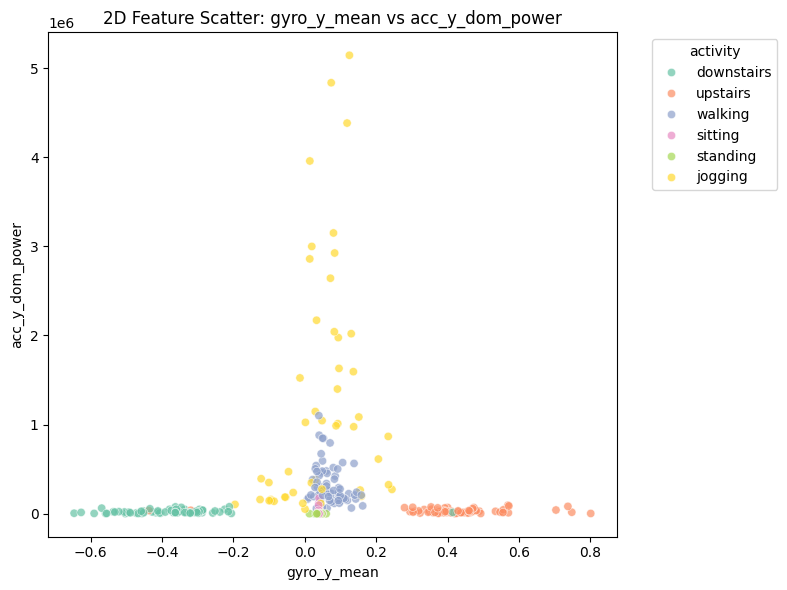

In [ ]:
plot_features(features_df, ['gyro_y_mean', 'acc_y_dom_power'])


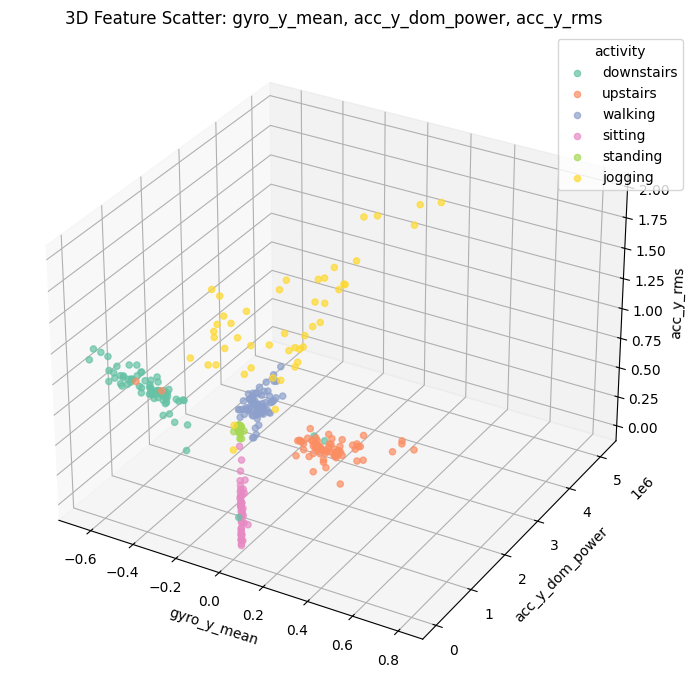

In [ ]:
plot_features(features_df, ['gyro_y_mean', 'acc_y_dom_power', 'acc_y_rms'])


### You will repeat this for the 10s-3s data

# What if 3 features are not enough to show the separability of the classes?

### Introduction to Popular Machine Learning Libraries

Several powerful libraries are widely used for tasks like data preprocessing, model training, and evaluation. Some of the most popular machine learning libraries include:

1. **NumPy** (introduced in tutorial 1)
   - **Purpose**: Provides support for large, multi-dimensional arrays and matrices, along with a collection of mathematical functions to operate on these arrays.

2. **Pandas** (introduced in tutorial 1)
   - **Purpose**: A library designed for data manipulation and analysis. It provides data structures like DataFrames, which are useful for handling structured datasets (_Remember! Pandas is the Excel in Python!_)

3. **Matplotlib and Seaborn** (introduced in tutorial 1)
   - **Purpose**: These libraries are used for data visualization. Matplotlib provides a flexible platform for creating static, animated, and interactive plots, while Seaborn simplifies the creation of informative and attractive statistical graphics.

# 4. **scikit-learn**
   - **Purpose**: A comprehensive library that provides simple and efficient tools for data mining and machine learning. It includes algorithms for classification, regression, clustering, dimensionality reduction, and more.


In [8]:
from sklearn.preprocessing import StandardScaler
import numpy as np


meta_cols = ['subject', 'activity', 'trial']
feature_cols = [c for c in features_df.columns if c not in meta_cols]

X = features_df[feature_cols].values
y = features_df['activity'].values

# Normalizing the data (necessary for PCA)
X_scaled = StandardScaler().fit_transform(X)

# Map string labels to integers for coloring
labels, y_numeric = np.unique(y, return_inverse=True)



# PCA

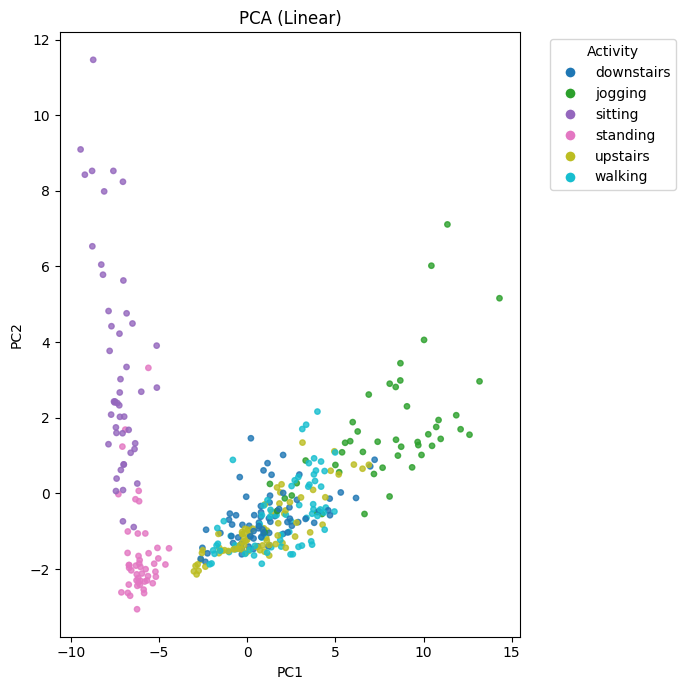

In [ ]:
from sklearn.decomposition import PCA


# PCA (Linear)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)


plt.figure(figsize=(7, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1],
                      c=y_numeric, cmap='tab10', s=15, alpha=0.8)

# Create legend mapping colors to activity labels
legend_handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=label,
               markerfacecolor=scatter.cmap(scatter.norm(i)), markersize=8)
    for i, label in enumerate(labels)
]

plt.legend(handles=legend_handles, title='Activity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('PCA (Linear)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()

### You will repeat this for the 10s-3s data


# Kernel PCA

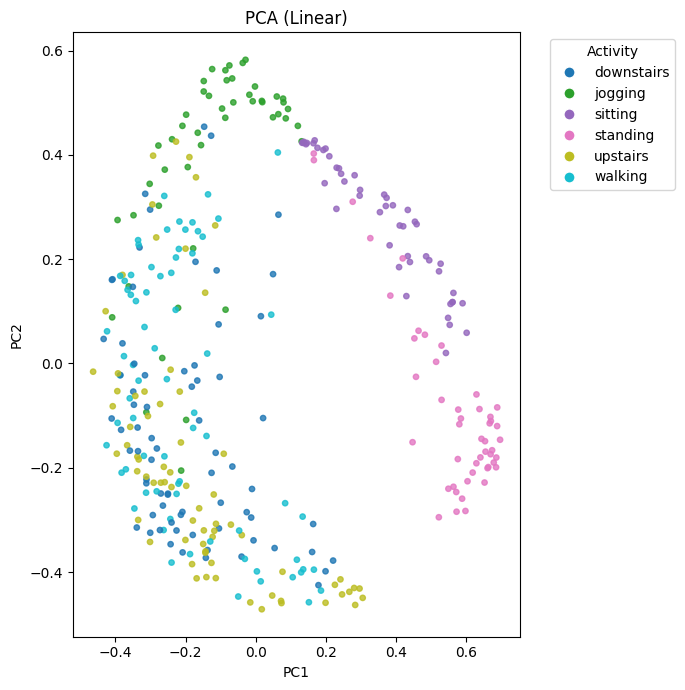

In [ ]:
from sklearn.decomposition import KernelPCA


# Kernel PCA (Non-linear) with RBF kernel
kpca = KernelPCA(n_components=2, kernel='rbf')
X_kpca = kpca.fit_transform(X_scaled)



plt.figure(figsize=(7, 7))
scatter = plt.scatter(X_kpca[:, 0], X_kpca[:, 1],
                      c=y_numeric, cmap='tab10', s=15, alpha=0.8)

# Create legend mapping colors to activity labels
legend_handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=label,
               markerfacecolor=scatter.cmap(scatter.norm(i)), markersize=8)
    for i, label in enumerate(labels)
]

plt.legend(handles=legend_handles, title='Activity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('PCA (Linear)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()

### You will repeat this for the 10s-3s data


# T-SNE

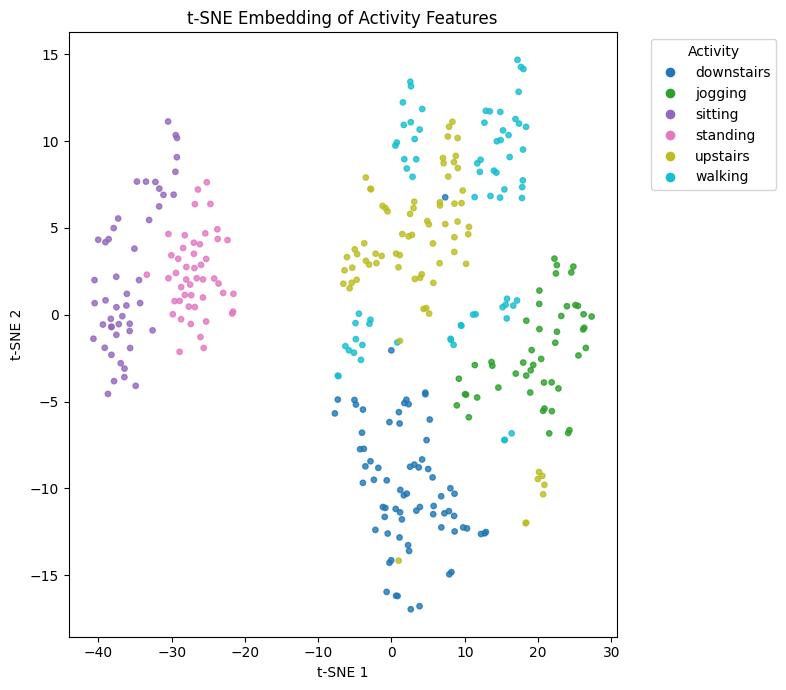

In [ ]:
from sklearn.manifold import TSNE

# --- Prepare data (assumes X_scaled, y, labels, y_numeric already defined) ---

# t-SNE (Non-linear)
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate='auto')
X_tsne = tsne.fit_transform(X_scaled)


plt.figure(figsize=(8, 7))
scatter = plt.scatter(
    X_tsne[:, 0], X_tsne[:, 1],
    c=y_numeric, cmap='tab10', s=15, alpha=0.8
)

# --- Legend mapping numeric colors to class labels ---
legend_handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=label,
               markerfacecolor=scatter.cmap(scatter.norm(i)), markersize=8)
    for i, label in enumerate(labels)
]

plt.legend(
    handles=legend_handles, title='Activity',
    bbox_to_anchor=(1.05, 1), loc='upper left'
)

plt.title('t-SNE Embedding of Activity Features')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.tight_layout()
plt.show()


### You will repeat this for the 10s-3s data


UMAP(n_neighbors=20, verbose=True)
Thu Oct 16 10:08:43 2025 Construct fuzzy simplicial set
Thu Oct 16 10:08:43 2025 Finding Nearest Neighbors
Thu Oct 16 10:08:43 2025 Finished Nearest Neighbor Search
Thu Oct 16 10:08:43 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Oct 16 10:08:44 2025 Finished embedding


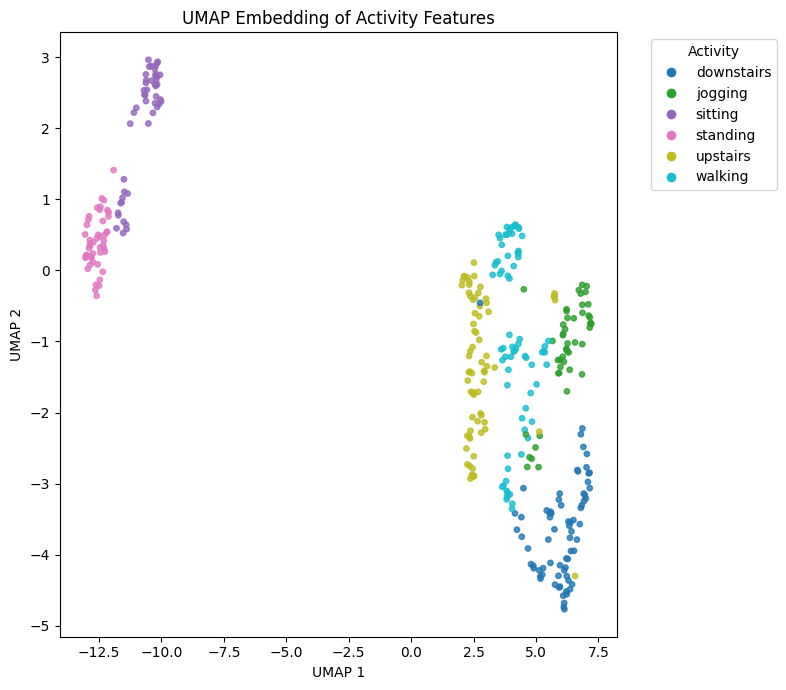

In [ ]:
import umap
import matplotlib.pyplot as plt
import numpy as np

# --- UMAP Configuration ---
umap_model = umap.UMAP(
    n_components=2,      # Reduce to 2D for visualization
    n_neighbors=20,      # Size of the local neighborhood (balance local vs global structure)
    min_dist=0.1,        # Minimum distance between embedded points (controls clustering tightness)
    metric='euclidean',  # Distance metric (e.g., 'euclidean', 'manhattan', 'cosine')
    spread=1.0,          # How spread out the embedding is overall
    # random_state=42,     # For reproducibility (set None for stochastic behavior)
    n_epochs=None,       # Let UMAP choose automatically
    learning_rate=1.0,   # Step size during optimization (usually leave default)
    n_jobs=-1,           # Use all cores for speed
    verbose=True         # Print progress messages
)

# --- Run UMAP (on standardized data) ---
X_umap = umap_model.fit_transform(X_scaled)

# --- Plotting ---
plt.figure(figsize=(8, 7))
scatter = plt.scatter(
    X_umap[:, 0], X_umap[:, 1],
    c=y_numeric, cmap='tab10', s=15, alpha=0.8
)

# --- Legend mapping numeric colors to class labels ---
legend_handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=label,
               markerfacecolor=scatter.cmap(scatter.norm(i)), markersize=8)
    for i, label in enumerate(labels)
]

plt.legend(
    handles=legend_handles, title='Activity',
    bbox_to_anchor=(1.05, 1), loc='upper left'
)

plt.title('UMAP Embedding of Activity Features')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.tight_layout()
plt.show()


### You will repeat this for the 10s-3s data


# Decision boundry

# An overview of model creation and decision boundries using scikit-learn
### **Step 1: Loading The Dataset**

```python
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
```

- **Explanation**:
  - `train_test_split(...)`: The data is split into training and testing sets. `test_size=0.2` means 20% of the data will be used for testing, and 80% for training.

---

### **Step 2: Standardize the Data**

```python
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
```

- **Objective**: Normalize the data so that all features have the same scale, which is crucial for PCA and many machine learning algorithms.
- **Explanation**:
  - `StandardScaler()`: This function standardizes features by removing the mean and scaling to unit variance.
  - `scaler.fit_transform(X_train)`: Fits the scaler to the training data and applies the transformation. This ensures that the training data has a mean of 0 and a standard deviation of 1 for each feature.
  - `scaler.transform(X_test)`: Applies the same transformation to the test data using the parameters learned from the training set.

---

### **Step 3: Apply PCA to Reduce to 2 Dimensions**

```python
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
```

- **Objective**: Reduce the dimensionality of the data to 2 components so that it can be visualized in a 2D plot.
- **Explanation**:
  - `PCA(n_components=2)`: Initializes PCA to reduce the data to 2 principal components.
  - `pca.fit_transform(X_train)`: Fits the PCA model to the training data and transforms it into the PCA space.
  - `pca.transform(X_test)`: Transforms the test data into the same PCA space, so both sets are projected onto the same 2D plane.

---

### **Step 4: Train a Classifier**

```python
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train_pca, y_train)
```

- **Objective**: Train a K-Nearest Neighbors (KNN) classifier on the PCA-reduced data.
- **Explanation**:
  - `KNeighborsClassifier(n_neighbors=5)`: Initializes a KNN classifier with 5 neighbors.
  - `clf.fit(X_train_pca, y_train)`: Fits the KNN model to the training data (`X_train_pca` is the PCA-transformed training data, and `y_train` is the corresponding label).

---

### **Step 5: Create a Meshgrid to Plot Decision Boundary**

```python
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
grid_x, grid_y = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
```

- **Objective**: Create a grid of points spanning the PCA-reduced feature space. This grid will be used to visualize the decision boundary.
- **Explanation**:
  - `X_train_pca[:, 0].min()` and `.max()`: Find the minimum and maximum values of the first principal component.
  - `X_train_pca[:, 1].min()` and `.max()`: Find the minimum and maximum values of the second principal component.
  - `np.meshgrid(...)`: Creates a 2D grid of points across the PCA space, with step size `0.1` between grid points.

---

### **Step 6: Predict Class for Each Point in the Meshgrid**

```python
Z = clf.predict(np.c_[grid_x.ravel(), grid_y.ravel()])
Z = Z.reshape(grid_x.shape)
```

- **Objective**: Use the classifier to predict the class label for each point in the grid, which will be used to plot the decision boundary.
- **Explanation**:
  - `grid_x.ravel()` and `grid_y.ravel()`: Flatten the meshgrid arrays into 1D arrays.
  - `np.c_[...]`: Combines the flattened grid arrays into a 2D array where each row is a (x, y) point.
  - `clf.predict(...)`: Predicts the class label for each point in the grid using the trained KNN classifier.
  - `Z.reshape(grid_x.shape)`: Reshapes the predicted labels back into the shape of the meshgrid for contour plotting.

---

### **Step 7: Plot the Decision Boundary and Scatter Plot of the Data**

```python
plt.contourf(grid_x, grid_y, Z, alpha=0.4, cmap=plt.cm.RdYlBu)
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, s=30, cmap=plt.cm.RdYlBu, edgecolors='k')
```

- **Objective**: Visualize the decision boundary (contour plot) and the actual training data points (scatter plot).
- **Explanation**:
  - `plt.contourf(grid_x, grid_y, Z, alpha=0.4, cmap=plt.cm.RdYlBu)`: Creates a filled contour plot based on the predicted class labels (`Z`). The different regions of the plot are colored according to the predicted class.
    - `alpha=0.4`: Makes the contour plot semi-transparent so the data points are still visible.
    - `cmap=plt.cm.RdYlBu`: Specifies the color map for the plot.
  - `plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, s=30, cmap=plt.cm.RdYlBu, edgecolors='k')`: Creates a scatter plot of the training data points, colored based on their true labels (`y_train`).

---

### **Legend for Class Labels**

```python
legend1 = plt.legend(*scatter.legend_elements(), title="Classes", loc="upper right")
plt.gca().add_artist(legend1)
```

- **Objective**: Add a legend to the plot that shows the class labels and their corresponding colors.
- **Explanation**:
  - `scatter.legend_elements()`: Creates legend entries for the unique class labels.
  - `plt.legend(...)`: Adds a legend to the plot, positioning it in the upper-right corner.
  - `plt.gca().add_artist(legend1)`: Adds the legend to the current axes.

---

### **Final Result**:

- **Decision boundary**: The contour plot shows the regions where the classifier predicts each class in the PCA-reduced space.
- **Scatter plot**: The data points are plotted in PCA space and colored by their true class labels, providing a clear visual comparison of the actual data and the decision boundary.

In [ ]:
from sklearn.svm import SVC

clf = SVC(kernel='linear', gamma='auto', C=1)
clf.fit(X_pca, y_numeric)


SVC(C=1, gamma='auto', kernel='linear')

In [ ]:
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
grid_x, grid_y = np.meshgrid(np.arange(x_min, x_max, 0.1),
                             np.arange(y_min, y_max, 0.1))


In [ ]:
Z = clf.predict(np.c_[grid_x.ravel(), grid_y.ravel()])
Z = Z.reshape(grid_x.shape)



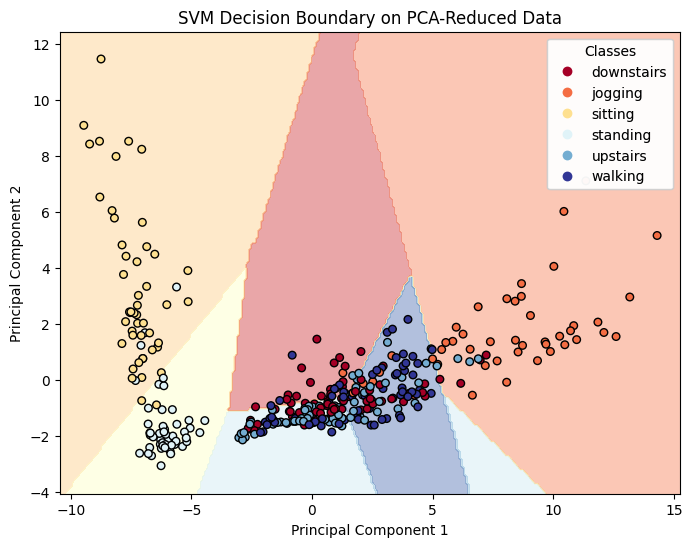

In [ ]:
plt.figure(figsize=(8, 6))
plt.contourf(grid_x, grid_y, Z, alpha=0.4, cmap=plt.cm.RdYlBu)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1],
                      c=y_numeric, s=30, cmap=plt.cm.RdYlBu, edgecolors='k')

# Create legend
legend1 = plt.legend(*scatter.legend_elements(), title="Classes", loc="upper right")

# Replace numeric labels with actual class names
for t, label in zip(legend1.texts, np.unique(y)):  # y contains your original class labels
    t.set_text(str(label))

plt.gca().add_artist(legend1)

plt.title("SVM Decision Boundary on PCA-Reduced Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


# A Small Exercise!

- Load the windowed data and create PCA, t-SNE, and UMAP embeddings for the data and visualize in 2-D.
- Conclude if the trial tabular data or the windowed tabular data was more separable (separable classes based on embeddings) and why!


